<a href="https://colab.research.google.com/github/fajemila/Zindi-Runmila-Tuberculosis-classification/blob/master/runmila%20optimized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip "/content/gdrive/My Drive/Runmila/images_fullsize.zip"

Archive:  /content/gdrive/My Drive/Runmila/images_fullsize.zip
   creating: test/
  inflating: test/TBLBHSYT.png       
  inflating: test/KHIMVBMD.png       
  inflating: test/RQZCAYRX.png       
  inflating: test/SMENQGVO.png       
  inflating: test/HLQHFYIS.png       
  inflating: test/UXFTRJWE.png       
  inflating: test/QUUDWCHL.png       
  inflating: test/RTAHZTRY.png       
  inflating: test/HIJQIQJT.png       
  inflating: test/FWEHCLXU.png       
  inflating: test/WTATMMWS.png       
  inflating: test/FTBBVMHK.png       
  inflating: test/PCPQBVFW.png       
  inflating: test/CMJPTDMO.png       
  inflating: test/FJQDGUND.png       
  inflating: test/TUSENBWD.png       
  inflating: test/KIRUHEIC.png       
  inflating: test/KBAKWKNW.png       
  inflating: test/LPFSZWIK.png       
  inflating: test/KVHDQRUE.png       
  inflating: test/UHRZNUCQ.png       
  inflating: test/RNEYKHMR.png       
  inflating: test/SIEWUKNU.png       
  inflating: test/AAKRKIZP.png       
  infl

In [3]:
!pip install efficientnet_pytorch torchtoolbox
!pip install resnet_pytorch

     |████████████████████████████████| 61kB 3.1MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16031 sha256=f1c3a331ec6ca231da26903f6257ecc02b777b3fc160065d49e47923b09f24fd
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [4]:
import warnings
warnings.filterwarnings('ignore')
import torch,torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold, GroupKFold,train_test_split
import pandas as pd
import torch
import numpy as np
import gc
import os
from PIL import Image
from PIL import ImageFile
import cv2
import time
import datetime
import warnings
import random
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations
from sklearn import metrics
from sklearn.model_selection import train_test_split
ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline

In [30]:
from keras.utils import to_categorical

In [5]:
!pip install wtfml

In [6]:
from wtfml.utils import EarlyStopping
from sklearn import model_selection

In [7]:
seed = 2020 # for reproductibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available(): 
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
os.getcwd()
labels = pd.read_csv('/content/gdrive/My Drive/Train.csv')
submission = pd.read_csv('/content/gdrive/My Drive/SampleSubmission.csv')
test = pd.read_csv('/content/gdrive/My Drive/Test.csv')


In [10]:
labels.head()

,filename,ID,LABEL
0,train/VTYNBFTO.png,VTYNBFTO,1
1,train/GVVXXDOZ.png,GVVXXDOZ,0
2,train/PMRSQLXN.png,PMRSQLXN,0
3,train/JXISWDUU.png,JXISWDUU,1
4,train/JVWMAACC.png,JVWMAACC,1


In [11]:
test.head()

,filename,ID
0,test/GTWSHFYQ.png,GTWSHFYQ
1,test/QTFSSMGD.png,QTFSSMGD
2,test/TBLBHSYT.png,TBLBHSYT
3,test/ZKETEOFG.png,ZKETEOFG
4,test/GKTPBGZP.png,GKTPBGZP


In [12]:
labels.tail()#test

,filename,ID,LABEL
713,train/EWGJDECH.png,EWGJDECH,1
714,train/CJEVKQUT.png,CJEVKQUT,1
715,train/YDXXBDGI.png,YDXXBDGI,1
716,train/QLUOORWZ.png,QLUOORWZ,0
717,train/HFAGCLGV.png,HFAGCLGV,1


In [13]:
labels['LABEL'].value_counts()

0    365
1    353
Name: LABEL, dtype: int64

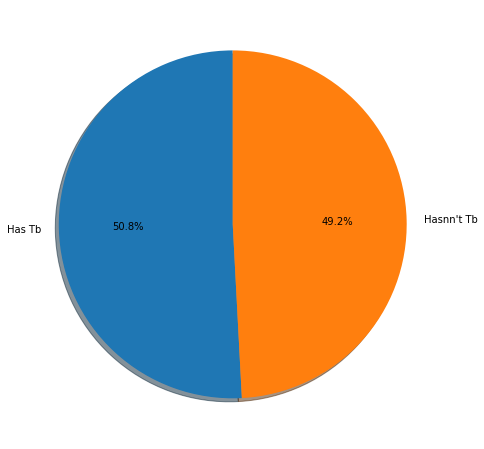

In [14]:
label = 'Has Tb' , "Hasnn\'t Tb"
plt.figure(figsize=(8,8))
plt.pie(labels.groupby('LABEL').size(),labels=label,autopct='%1.1f%%',shadow=True,startangle=90)
plt.show()

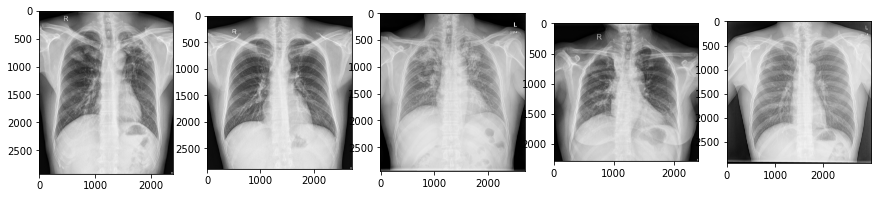

In [15]:
import matplotlib.image as img
fig,ax = plt.subplots(1,5,figsize=(15,3))

for i,idx in enumerate(labels[labels['LABEL'] == 1]['filename'][-5:]):
    path = idx
    ax[i].imshow(img.imread(path))

**cropping**

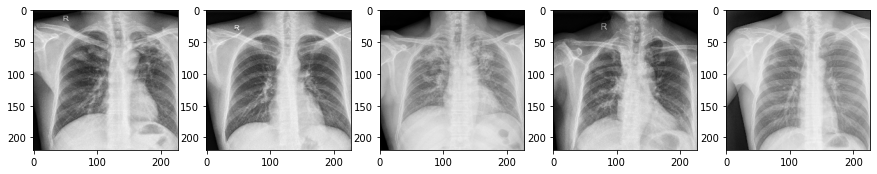

In [16]:
import cv2

fig,ax = plt.subplots(1,5,figsize=(15,3))
for i,ind in enumerate(labels[labels['LABEL']==1]['filename'][-5:]):
  patth = ind
  image = cv2.imread(ind)
  image = cv2.resize(image,dsize= (256,256))
  image = image[0:220, 0:227]
  ax[i].imshow(image)

In [17]:
from PIL import Image
import cv2
for ind in labels[labels['LABEL']==1]['filename'][-5:]:
    pathe = ind

    imgr = cv2.imread(pathe)
    imgr = cv2.resize(imgr,dsize=(256,256))

    print(imgr.size)
    print(imgr.shape)

196608
(256, 256, 3)
196608
(256, 256, 3)
196608
(256, 256, 3)
196608
(256, 256, 3)
196608
(256, 256, 3)


In [ ]:
class RunmilaDataset(Dataset):
    def __init__(self, data, path , traindata = None, transform = None):
        super().__init__()
        self.data = data
        self.path = path
        self.transform = transform
        self.traindata = traindata
    def __len__(self):
        return len(self.data)
    def __getitem__(self,index):
        img_path = self.data.iloc[index]['filename']
        #image = img
        image = cv2.imread(img_path)
        image = torch.Tensor(cv2.resize(image,dsize= (256,256))).permute(2,0,1)
        image = image[0:224, 0:224]
        if self.transform:#s:
            image = self.transform(image)#s(image)
            
        if self.traindata:
            label = self.data.iloc[index]['LABEL']
            return image,label
        else:
            return image

In [31]:
class RunmilaTDataset:
    def __init__(self,image_paths,targets,resize=None,augmentations=None):
        self.image_paths = image_paths
        self.targets = targets
        self.resize = resize
        self.augmentations = augmentations
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, item):
        image = Image.open(self.image_paths[item])
        image = image.convert("RGB")
        targets = self.targets[item]
        if self.resize is not None:
            image = image.resize(
                        (self.resize[1], self.resize[0]),
                        resample=Image.BILINEAR
            )
        image = np.array(image)
        if self.augmentations is not None:
            augmented = self.augmentations(image=image)
            image = augmented["image"]
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        return {
            "image": torch.tensor(image, dtype=torch.float),
            "targets": torch.tensor(to_categorical(targets,2), dtype=torch.long),
        }

In [33]:
# engine.py
import torch
import torch.nn as nn
from tqdm import tqdm
def train_fn(data_loader, model, optimizer, device):
    avg_loss = 0
    model.train()
    for data in data_loader:
        inputs = data["image"]
        targets = data["targets"]
        inputs = inputs.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = nn.BCEWithLogitsLoss()(outputs, targets)
        loss.backward()
        optimizer.step()
        avg_loss+=loss.item()* data["image"].size(0)

    # avg_loss_nump = avg_loss.cpu().detach().numpy()
    print('[Training] Loss: {:.5f}'.format( avg_loss/len(data_loader.sampler)))


In [37]:
def evaluate(data_loader, model, device):
    model.eval()
    final_targets = []
    final_outputs = []
    avg_loss = 0
    with torch.no_grad():
        for data in data_loader:
            inputs = data["image"]
            targets = data["targets"]
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)
            output = model(inputs)
            loss = nn.BCEWithLogitsLoss()(output, targets)
            targets = targets.detach().cpu().numpy().tolist()
            output = output.detach().cpu().numpy()[:,1].tolist()
            final_targets.extend(targets)
            final_outputs.extend(output)
            avg_loss+=loss.item()* data["image"].size(0)
    print('[Evaluation] Loss: {:.5f}'.format(avg_loss/len(data_loader.sampler)))
    return final_outputs, final_targets

In [ ]:
def predict(data_loader, model, device):
    model.eval()
    final_outputs = []
    with torch.no_grad():
        for data in data_loader:
            inputs = data["image"]
            inputs = inputs.to(device, dtype=torch.float)
            output = model(inputs)
            output = output.detach().cpu().numpy().tolist()
            final_outputs.extend(output)
    return final_outputs

In [ ]:
# model.py
import torch.nn as nn
import pretrainedmodels
def get_model(pretrained):
    if pretrained:
      model = torchvision.models.densenet121(pretrained=True)
      num_ftrs = model.classifier.in_features
      model.classifier = nn.Linear(num_ftrs, 1)
    #     model = pretrainedmodels.__dict__["densenet161"](
    #     pretrained='imagenet'
    #     )
    # else:
    #     model = pretrainedmodels.__dict__["densenet161"](
    #     pretrained=None
    #     )
    # print the model here to know whats going on.
    # model.last_linear = nn.Sequential(
    #     nn.BatchNorm1d(512),
    #     nn.Dropout(p=0.25),
    #     nn.Linear(in_features=512, out_features=2048),
    #     nn.ReLU(),
    #     nn.BatchNorm1d(2048, eps=1e-05, momentum=0.1),
    #     nn.Dropout(p=0.5),
    #     nn.Linear(in_features=2048, out_features=1),
    #     )
   
    return model


In [21]:
# create folds
df = pd.read_csv('/content/gdrive/My Drive/Train.csv')
df["kfold"] = -1    
df = df.sample(frac=1).reset_index(drop=True)
y = df.LABEL.values
kf = model_selection.StratifiedKFold(n_splits=5)

for f, (t_, v_) in enumerate(kf.split(X=df, y=y)):
    df.loc[v_, 'kfold'] = f

df.to_csv("train_folds.csv", index=False)

In [24]:
from torch.nn import functional as F

In [25]:
class Model(nn.Module):
    def __init__(self, arch):
        super(Model, self).__init__()
        self.arch = arch
        if 'ResNet' in str(arch.__class__):
            self.arch.fc = nn.Linear(in_features=512, out_features=2, bias=True)
        if 'EfficientNet' in str(arch.__class__):
            self.arch._fc = nn.Linear(in_features=1280, out_features=2, bias=True)
        if 'DenseNet' in str(arch.__class__):
            self.arch.classifier = nn.Linear(in_features=1024, out_features=2, bias=True)
        self.Linear = nn.Linear(1024,2)
    def forward(self, inputs):
        x = inputs
        x = self.arch(x)
        # x = self.Linear(x)
        x = F.sigmoid(x)
        return x

In [28]:
def train(fold):
    training_data_path = '/content/' 
    df =  pd.read_csv("/content/train_folds.csv")
    device = "cuda"
    epochs = 50
    train_bs = 16
    valid_bs = 16

    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    arch = torchvision.models.densenet121(pretrained=True)
    model = Model(arch=arch)
    model.to(device)
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    train_aug = albumentations.Compose([albumentations.CenterCrop(227,227),
                                        albumentations.Normalize(mean, std, max_pixel_value=255.0, always_apply=True),
            albumentations.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15),
            albumentations.Flip(p=0.5)])

    valid_aug = albumentations.Compose([albumentations.CenterCrop(227,227),albumentations.Normalize(mean, std, max_pixel_value=255.0, always_apply=True)])

    train_images = df_train.filename.values.tolist()
    train_images = [os.path.join(training_data_path, i) for i in train_images]
    train_targets = df_train.LABEL.values

    valid_images = df_valid.filename.values.tolist()
    valid_images = [os.path.join(training_data_path, i) for i in valid_images]
    valid_targets = df_valid.LABEL.values

    train_dataset = RunmilaTDataset(image_paths=train_images,targets=train_targets,resize=(256, 256),augmentations=train_aug)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_bs, shuffle=True, num_workers=4)

    valid_dataset = RunmilaTDataset(image_paths=valid_images,targets=valid_targets, resize=(256, 256),augmentations=valid_aug)


    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=valid_bs, shuffle=False, num_workers=4)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=3,threshold=0.001,mode="max")

    es = EarlyStopping(patience=5, mode="max")

    for epoch in range(epochs):
        train_loss = train_fn(train_loader, model, optimizer, device=device)
        predictions, valid_loss = evaluate(
            valid_loader, model, device=device
        )
        roc_score = metrics.roc_auc_score(valid_targets, predictions)
        print(f"Epoch = {epoch}, ROC_SCORE = {roc_score}")
        scheduler.step(roc_score)#auc)

        es(roc_score, model, model_path=f"model_fold_{fold}.bin")
        if es.early_stop:
            print("Early stopping")
            break#l

In [39]:
train(0)
train(1)
train(2)
train(3)
train(4)

[Training] Loss: 0.71905
[Evaluation] Loss: 0.70873
Epoch = 0, ROC_SCORE = 0.6965078140073316
Validation score improved (-inf --> 0.6965078140073316). Saving model!
[Training] Loss: 0.70293
[Evaluation] Loss: 0.69100
Epoch = 1, ROC_SCORE = 0.8425622226509744
Validation score improved (0.6965078140073316 --> 0.8425622226509744). Saving model!
[Training] Loss: 0.68820
[Evaluation] Loss: 0.67190
Epoch = 2, ROC_SCORE = 0.875361759598688
Validation score improved (0.8425622226509744 --> 0.875361759598688). Saving model!
[Training] Loss: 0.67111
[Evaluation] Loss: 0.65166
Epoch = 3, ROC_SCORE = 0.887709820567239
Validation score improved (0.875361759598688 --> 0.887709820567239). Saving model!
[Training] Loss: 0.65391
[Evaluation] Loss: 0.63415
Epoch = 4, ROC_SCORE = 0.8954273586725835
Validation score improved (0.887709820567239 --> 0.8954273586725835). Saving model!
[Training] Loss: 0.63761
[Evaluation] Loss: 0.61953
Epoch = 5, ROC_SCORE = 0.9025660814200269
Validation score improved (0.89

In [40]:
class RunmilaTDatasetTest:
    def __init__(self,image_paths,resize=None,augmentations=None):
        self.image_paths = image_paths
        self.resize = resize
        self.augmentations = augmentations
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, item):
        image = Image.open(self.image_paths[item])
        image = image.convert("RGB")
        if self.resize is not None:
            image = image.resize(
                        (self.resize[1], self.resize[0]),
                        resample=Image.BILINEAR
            )
        image = np.array(image)
        if self.augmentations is not None:
            augmented = self.augmentations(image=image)
            image = augmented["image"]
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        return {
            "image": torch.tensor(image, dtype=torch.float),

        }

In [41]:
n_folds = 5

In [52]:
def predict(df, MODELS, bs=16):
    training_data_path = "/content/test"
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    test_aug = albumentations.Compose([albumentations.CenterCrop(227,227),albumentations.Normalize(mean, std, max_pixel_value=255.0, always_apply=True)])
    test_images = df.ID.values.tolist()
    test_images = [os.path.join(training_data_path, i +'.png') for i in test_images]
    test_ds = RunmilaTDatasetTest(image_paths=test_images,resize=(256, 256),augmentations=test_aug)
    testloader = torch.utils.data.DataLoader(test_ds, bs, shuffle=False)

    predictions_labels = []
    predictions_proba = []

    out = None

    for data in testloader:
        x = data['image'].to(device)

        for i in range(n_folds):
            if i == 0: out = MODELS[i](x)
            else: out += MODELS[i](x)

        out /= n_folds
        out_labels = out.argmax(1).cpu().detach().numpy()
        out_probas = out.cpu().detach().numpy()

        predictions_labels += out_labels.tolist()
        predictions_proba += out_probas.tolist()

    return predictions_labels ,predictions_proba

In [53]:
def load_models():
    arch = torchvision.models.densenet121(pretrained=True)
    MODELS = []
    
    for i in range(n_folds):
        MODELS.append(Model(arch=arch) )
        MODELS[i].to(device)
        MODELS[i].load_state_dict(torch.load(f"model_fold_{i}.bin"))
        MODELS[i].eval()
        
    return MODELS

In [45]:
sub.head()

,ID,LABEL
0,GTWSHFYQ,0
1,QTFSSMGD,0
2,TBLBHSYT,0
3,ZKETEOFG,0
4,GKTPBGZP,0


In [54]:
sub = pd.read_csv('/content/gdrive/My Drive/SampleSubmission.csv')
MODELS = load_models()

# 2
predictions_labels, predictions_proba = predict(sub, MODELS=MODELS, bs=8)

In [56]:
submission = pd.DataFrame()
submission['ID'] = sub['ID']
for i, label in enumerate(["0", "1"]):
    submission[label] = 0
for i, label in enumerate(["0", "1"]):
    submission.loc[:,label] = np.array(predictions_proba)[:,i]
submission['target'] = predictions_labels

submission.head()

,ID,0,1,target
0,GTWSHFYQ,0.812888,0.058927,0
1,QTFSSMGD,0.992227,0.005469,0
2,TBLBHSYT,0.022064,0.976362,1
3,ZKETEOFG,0.408643,0.379038,0
4,GKTPBGZP,0.120579,0.613359,1


In [57]:
subs = submission[['ID', '1']]
subs.columns = ['ID','LABEL']
subs.to_csv(f'runmilla_dense121_1e-5.csv', index=False)
# subs.to_csv(f'spot_{arch}_folds_{n_folds}_epochs_{epochs}_size_{size}_LR_{lr}.csv', index=False)

In [ ]:
data_path = '/content/images/'
epochs = 10
df = pd.read_csv('/content/gdrive/My Drive/Train.csv')
submission = pd.read_csv('/content/gdrive/My Drive/SampleSubmission.csv')
images = df.filename.values.tolist()
# images = [os.path.join(data_path, i) for i in images]

targets = df.LABEL.values
model = get_model(pretrained=True)
model.to(device)
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
aug = albumentations.Compose([albumentations.Normalize(mean, std, max_pixel_value=255.0, always_apply=True)])
train_images, valid_images, train_targets, valid_targets =train_test_split(images, targets, stratify=targets, random_state=42)
train_dataset = SpotMaskDataset(image_paths=train_images,targets=train_targets,resize=(227, 227),augmentations=aug)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_dataset = SpotMaskDataset(image_paths=valid_images,targets=valid_targets, resize=(227, 227),augmentations=aug)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
for epoch in range(epochs):
    train(train_loader, model, optimizer, device=device)
    predictions, valid_targets = evaluate(valid_loader, model, device=device)
    log_loss = metrics.log_loss(valid_targets, predictions)
    print(f"Epoch={epoch}, Valid LOG_LOSS={log_loss}")

In [ ]:
model_ft = torchvision.models.resnet18(pretrained=True)#lr=e4,2epoch 92, lr=e5,4epoch93
# set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)
model_ft.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_ft.parameters(),lr = learning_rate)

In [ ]:
model = torch.load()
predictions = predict(sub_loader,model,device)
submission['target'] = predictions

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b1')
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs,1)
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

Loaded pretrained weights for efficientnet-b1


In [ ]:
from torch.optim import lr_scheduler

In [ ]:
model_ft = torchvision.models.alexnet(pretrained=True)#lr=e4,4epoch 90.9 e5 86
# set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
model_ft.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_ft.parameters(),lr = learning_rate)

In [ ]:
model_ft = torchvision.models.vgg11_bn(pretrained=True)#lr=e4,1epo ch 91 e5 93.5
# set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
model_ft.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_ft.parameters(),lr = learning_rate)

In [ ]:
model_ft = torchvision.models.densenet121(pretrained=True)
# set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, num_classes)
model_ft.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_ft.parameters(),lr = learning_rate)

In [ ]:
#freeze resnet upper weights and set epoch to 10